In [1]:
import scipy.stats as sps
import numpy as np
import matplotlib.pyplot as plt
import ReliabilityAnalysis as ra

# Example 1
*The lifetime of a certain device is exponentially distributed with a mean value of 500 hours. What is the probability of this device operating for 600 hours?*

**Solution.** 
The failure times $T$ satisfy
$$ T\sim\mathrm{Exp}\left(\lambda\right) $$
where "$\sim$" can be read as "distributed as". The lone parameter is $\lambda$, which can be computed as
$$\lambda = \frac{1}{MTTF}$$
and the probability of operating for 600 hours is simply the reliability
$$R(600) = 1-F(600)$$
We can use the reliability module (with scipy.stats) to evaluate this:

In [2]:
pd = ra.expdist()
pd = pd(scale=500)
R1 = pd.reliability(600)
print("The probability of surviving 600 hours is {:.1f}%".format(R1*100))

The probability of surviving 600 hours is 30.1%


# Example 2
*Significant rail defects in a particular corridor occur at an average rate of one every three months. Significant rail defects in a particular corridor occur at an average rate of one every three months. Answer the following:*

*1. What is the probability of two failures occurring less than one month apart?*  
*2. What is the probability that there are more than 5 failures in a year?*

**Solution.** Let $X$ denote the time between failure events. Assuming that the average rate is constant implies that $X\sim \mathrm{Exp}(\lambda)$ with $\lambda=\frac{1}{3}$ failures per month. This can be seen by noting that the number of failures in a time interval $k$ follows a Poisson distribution when the average arrival rate is constant. Thus, the probability that k=0 events occur in time $\Delta t$ is
\begin{align*}
\mathbb{P}\left[ k=0 \right] & = 1-\mathbb{P}\left[ k\geq 0 \right] \\
                             & = \frac{(\lambda \Delta t)^k e^{-\lambda \Delta t}}{k!} \\
                             & = \frac{(\lambda \Delta t)^0 e^{-\lambda \Delta t}}{0!} \\
                             & = e^{-\lambda \Delta t} \\
\end{align*}
The probability that two failures occur less than one month apart is equivalent to the inter-failure time being less than one month, i.e.
\begin{align*}
\mathbb{P}\left[ k\geq1 \right] & = 1-e^{-\frac{1}{3}\cdot 1} \\
\end{align*}
which is just the CDF of the exponential distribution. Using scipy.stats:

In [3]:
pd1 = ra.expdist()
answer1 = pd1.cdf(1.0,scale=3) # one month
print("The probability of two failures occuring within a month of each other is {:.2f}%".format(answer1*100))

The probability of two failures occuring within a month of each other is 28.35%


For 2, we note that $k\sim\mathrm{Poisson}(\lambda\Delta t)$ and we can evaluate this using scipy.stats as

In [4]:
pd2 = sps.poisson(mu=1/3*12)
answer2 = 1-pd2.cdf(5)
print("The probability of more than 5 failures occuring within a year is {:.2f}%".format(answer2*100))

The probability of more than 5 failures occuring within a year is 21.49%


# Example 3
*A machine model you want to acquire has a Weibull reliability profile with $\beta=0.8$ and $\eta=30$ years. Any failure of the machine would cost 200,000. On the market you find:*  
1. *a new machine for 2M and*  
2. *a 5-year-old one for 1.8M*

*Which one do you buy?*

**Solution.**
We begin by noting that the reliability of the new machine is
\begin{align}
    R(t) & = \exp\left[-\left(\frac{t}{30} \right)^{0.8} \right]
\end{align}
while the reliability of the five-year-old machine is
\begin{align}
    R(t+5\mid 5) & = \exp\left[-\left(\frac{t+5}{30} \right)^{0.8} + \left(\frac{5}{30} \right)^{0.8} \right]
\end{align}
It's not immediately obvious which reliability is better, so we plot them. First, let's define the conditional reliability distribution as a custom distribution

Text(0, 0.5, '$\\lambda(t)$')

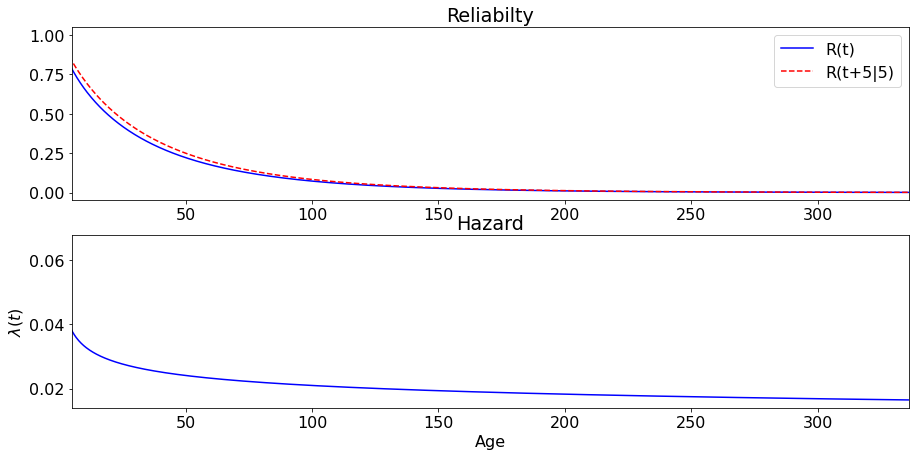

In [5]:
eta = 30
beta = 0.8
t0 = 5
pd = ra.weibull()
pd = pd(beta,scale=eta)
MTTF = pd.mean()

plt.rcParams.update({'font.size': 16})
fig,axs = plt.subplots(2,1,figsize=(15,7))
t = np.linspace(0,pd.ppf(0.999),num=1000) # ppf is the inverse CDF, which is a bit of a silly name
axs[0].plot(t,1-pd.cdf(t),color='blue',label="R(t)")
axs[0].plot(t,pd.conditional_reliability(t,t0),color='red',linestyle='--',label="R(t+5|5)")
axs[0].set_xlim((5,pd.ppf(0.999)))
axs[0].legend()
axs[0].set_title("Reliabilty")

axs[1].plot(t,pd.hazard(t),color='blue')
axs[1].set_xlim((5,pd.ppf(0.999)))
axs[1].set_title("Hazard")
axs[1].set_xlabel("Age")
axs[1].set_ylabel("$\lambda(t)$")

We can see that the older asset has higher reliabilty due to its suvival of a portion of its infant mortality period. Thus, we should *definitely* purchase the fine-year-old one.

# Example 4
Empirical CDF with complete data using various methods.

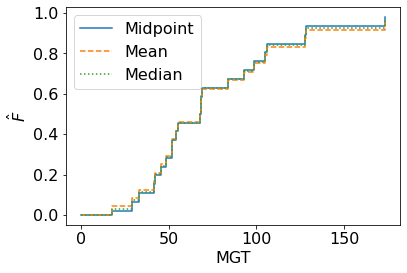

In [6]:
ti = [128.04, 93.12, 67.8, 68.64, 84.12, 17.88, 105.84, 28.92, 33, 41.52, 42.12, 68.88, 45.6, 48.4, 51.84, 51.96, 68.64, 54.12, 98.64, 127.92, 55.56, 105.12, 173.40]
ti = np.array(ti)
observed = np.ones(ti.shape)

t1,Fhat1 = ra.ecdf(ti,observed,plot=False)
t2,Fhat2 = ra.ecdf(ti,observed,pos="mean",plot=False)
t3,Fhat3 = ra.ecdf(ti,observed,pos="median",plot=False)

fig, ax = plt.subplots()
ax.step(t1,Fhat1,where="post",label="Midpoint")
ax.step(t2,Fhat2,'--',where="post",label="Mean")
ax.step(t3,Fhat3,':',where="post",label="Median")
ax.set_xlabel("MGT")
ax.set_ylabel("$\hat{F}$")    
ax.legend()

# Example 5
First, we compute the Kaplan Meier empirical CDF. 

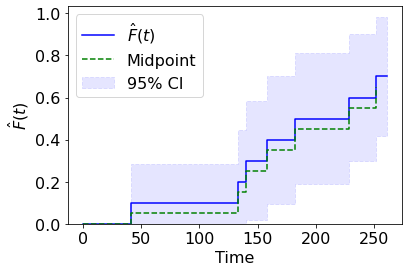

In [7]:
ti = [251.3, 133.3, 139.9, 261.3, 261.3, 181.9, 41.0, 228.8, 158.4, 261.3]
ti = np.array(ti)
observed = np.ones(ti.shape)
observed[ti==261.3] = 0 # censor#ed
tkm,Fhat,LCI,UCI,figKM,axKM = ra.kaplan_meier(ti,observed,plot=True,confidence_interval="greenwood")

# add midpoint to the plot
tkm2,Fhat2 = ra.ecdf(ti,observed,plot=False)
axKM.step(tkm2,Fhat2,linestyle='--',color="green",where="post",label="Midpoint")
plt.legend()


# Example 6
Now, we fit a Weibull using MLE. Note that the weibull_fit fuction is a custom function I'm using because the scipy.stats fitting functions don't seem to support censoring:

In [8]:
pdhat = ra.weibull()
p,pci,p_cov= pdhat.fit(ti,[np.mean(ti),1],observed=observed)
eta_hat = p[0]
beta_hat = p[1]
pdhat = pdhat(beta_hat,scale=eta_hat) # Call distribution with parameters to "freeze" it
fmt = " eta_hat:\t{0:.2f}\t CI = [{1:.2f}, {2:.2f}] \n beta_hat:\t{3:.2f}\t CI = [{4:.2f}, {5:.2f}]"
print(fmt.format(eta_hat,pci[0,0],pci[0,1],beta_hat,pci[1,0],pci[1,1]))

 eta_hat:	242.80	 CI = [159.33, 326.26] 
 beta_hat:	2.17	 CI = [0.73, 3.61]


And we plot the results

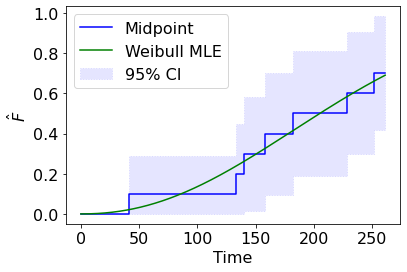

In [9]:
t = np.linspace(0,np.max(ti),1000)
figKM, axKM = plt.subplots()
axKM.step(tkm,Fhat,linestyle='-',color="blue",where="post",label="Midpoint")
axKM.fill_between(tkm,LCI,y2=UCI,linestyle=':',color="blue",step="post",label="95% CI",alpha=0.1)
axKM.plot(t,pdhat.cdf(t),linestyle='-',color='green',label="Weibull MLE")
axKM.set_xlabel("Time")
axKM.set_ylabel("$\hat{F}$")    
axKM.legend(loc='upper left')

# Example 7
Use graphical fitting techniques to obtain Weibull parameter estimates

In [10]:
tmid,Fhatmid = ra.ecdf(ti,observed,plot=False) # Using midpiont ECDF from above
y = np.log(-np.log(1-Fhatmid[1::])) # omit first point (zero). 
x = np.log(tmid[1::])

We now fit a line to this data to obtain the estimates for $\eta$ and $\beta$

In [11]:
slope, intercept, r_value, p_value, std_err = sps.linregress(x,y)
beta = slope
eta = np.exp(-intercept/beta)
dist = ra.weibull()
dist = dist(beta,scale=eta)

<AxesSubplot:xlabel='$\\log(Time)$', ylabel='$F(t)$'>

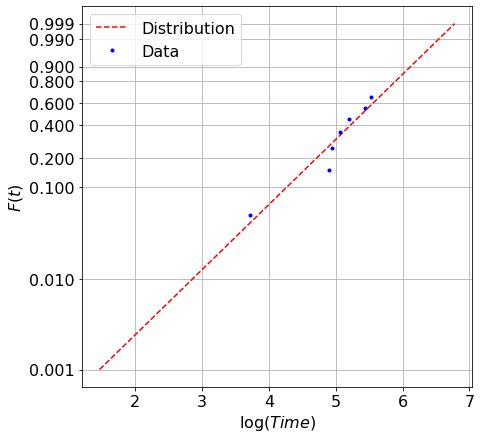

In [12]:
data = {'times':tmid[1::],'ecdf':Fhatmid[1::]}
fig,ax = plt.subplots(figsize=(7,7))
ra.weibull_probability_plot(dist,data=data,ax=ax)

Now we add this to the empirical plot from before:

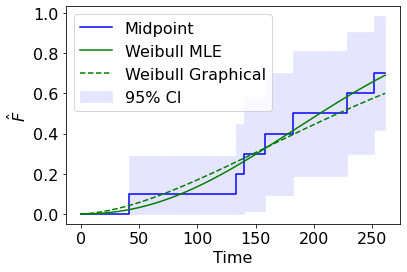

In [13]:
figKM, axKM = plt.subplots()
axKM.step(tkm,Fhat,linestyle='-',color="blue",where="post",label="Midpoint")
axKM.fill_between(tkm,LCI,y2=UCI,linestyle=':',color="blue",step="post",label="95% CI",alpha=0.1)
axKM.plot(t,pdhat.cdf(t),linestyle='-',color='green',label="Weibull MLE")
axKM.set_xlabel("Time")
axKM.set_ylabel("$\hat{F}$")    
axKM.plot(t,dist.cdf(t),linestyle='--',color='green',label="Weibull Graphical")
axKM.legend(loc='upper left')

We'll repeat the above with MLE estimates and confidence intervals

<AxesSubplot:xlabel='$\\log(Time)$', ylabel='$F(t)$'>

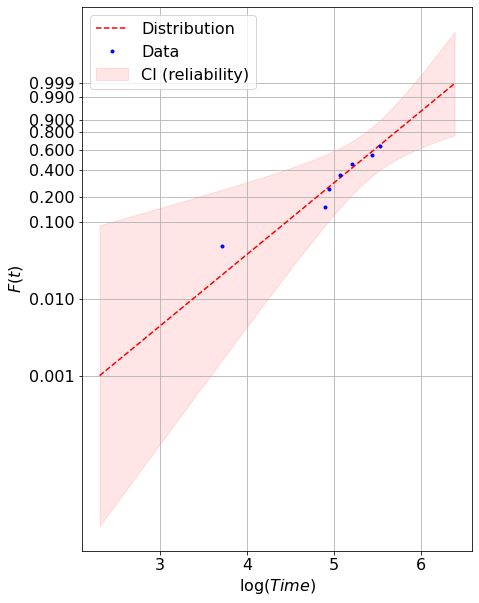

In [19]:
fig,ax2 = plt.subplots(figsize=(7,8)
ra.weibull_probability_plot(pdhat,data=data,ax=ax2,confidence_bounds="Reliability",parameter_covariance=p_cov)

# Example 8: Example from Crow's Classic Paper
In this example, Crow simulated age data for three assets ($M=3$) with $\gamma=0.6$ and $\beta=0.5$. Note that alternatively, this could be viewed as age data coming from a single asset which has been repaired perfectly three times. The below code performs MLE on this data. Note that Crow's data is time censored at $T=T_1=T_2=T_3=200$.

In [ ]:
event_times =   [   [4.3,4.4,10.2,23.5,23.8,26.4,74.0,77.1,92.1,197.2],
                    [0.1,5.6,18.6,19.5,24.2,26.7,45.1,45.8,75.7,79.7,98.6,120.1,161.8,180.6,190.8],\
                    [8.4,32.5,44.7,48.4,50.6,73.6,98.7,112.2,129.8,136.0,195.8]
                ]
censoring_times = [200]*3
intensity = lambda t,a,b: a*b*t**(b-1)
# plnhpp = ra.poisson_process(intensity_function=intensity,parameters=[])
plnhpp = ra.power_law_nhpp(1,1)
p_hat,p_ci,_ = plnhpp.fit(event_times,truncation_times=censoring_times)
fmt = " a_hat:\t{0:.2f}\t CI = [{1:.2f}, {2:.2f}] \n b_hat:\t{3:.2f}\t CI = [{4:.2f}, {5:.2f}]"
print(fmt.format(p_hat[0],p_ci[0,0],p_ci[0,1],p_hat[1],p_ci[1,0],p_ci[1,1]))

# Example 9: Plotting the Emperical MCF
Example from Tobias and Trindale, Chapter 12

In [ ]:
failures = [    [222,584,985,1161],\
                [273,766,1054],\
                [125,323],\
                [63,195,325],\
                [91,427,761,1096,1796] ]
suspension_times = [1901,1316,442,636,2214]
t,M,ML,MU,f,a = ra.empirical_mean_cumulative_function(failures,suspension_times,confidence_interval="logit")
crow = ra.power_law_nhpp(1,1)
p_hat,p_ci,_ = crow.fit(failures,truncation_times=suspension_times)
crow.parameters = p_hat
t = np.linspace(0,t[-1],100)
a.plot(t,crow.cumulative_intensity(t),label='PL-NHPP Fit',color='red',linestyle='--')
plt.legend()
ML

# Example 10: Emperical MCF
Consider the five identical asset example from http://reliawiki.org/index.php/Recurrent_Event_Data_Analysis:

| Asset | Failure Times |
|-------|---------------|
|1      | 5,10,15,17+   |
|2      | 6,13,17,19+   |
|3      | 12,20,25,26+  |
|4      | 13, 15, 24+   |
|5      | 16,22,25,28+  |

where the + indicates censoring

In [ ]:
failures = [    [5,10,15],\
                [6,13,17],\
                [12,20,25],\
                [13,15],\
                [16,22,25] ]
suspension_times = [17,19,26,24,28]
t,M,ML,MU,f,a = ra.empirical_mean_cumulative_function(failures,suspension_times=suspension_times,confidence_interval="logit")
crow = ra.power_law_nhpp(1,1)
p_hat,p_ci,_ = crow.fit(failures,truncation_times=suspension_times)
crow.parameters = p_hat
t = np.linspace(0,t[-1],100)
a.plot(t,crow.cumulative_intensity(t),label='PL-NHPP Fit',color='red',linestyle='--')
plt.legend()

# Example 10: A system with imperfect overhauls
From Shin et al. 

In [ ]:
failures = [[116,151,213,386,387,395,407,463,492,494,501,537,564,590,609]]
suspension_times = [609]
t,M,ML,MU,f,a = ra.empirical_mean_cumulative_function(failures,suspension_times,confidence_interval="normal")